<a href="https://colab.research.google.com/github/Kuehl-California-notebooks/Water_classification_Behave_Together/blob/main/Water_classification_Behave_Together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Perform exploratory data analysis

In this section, we first load the dataset into a `pandas` dataframe and then perform
some basic exploratory data analysis (EDA).

In [ ]:
raw_water_data = pd.read_csv('https://raw.githubusercontent.com/ekirchman/RIPS-notebooks/master/twitsamp11.15.csv')
raw_water_data.head()

,Unnamed: 0,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,...,Information,Motivation,Skills,Unnamed: 100,Subsidy,Bill,Unnamed: 103,Regulations,Behavioral,Incentives
0,318,2.458856e+08,6.950000e+17,1454439520,OtayWater,¡Californianos continúan cumpliendo con el man...,Twitter Web Client,140,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,643,6.023518e+08,1.070000e+18,1544807843,CITYSEM,Little League Registration Info. https://t.co/...,Facebook,56,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13,1.614689e+08,1.200000e+18,1575493955,COGWaterPower,Make your yard beautiful with permeable surfac...,Twitter Web App,144,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14,2.327619e+09,7.880000e+17,1476747592,DWAwater,DWA customers saved 8% in September. Our goal ...,Twitter Web Client,131,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,16,2.405357e+07,8.500000e+17,1491432440,CCWD,@CCWD's Los Vaqueros Reservoir was looking lov...,Twitter for iPhone,122,NaN,24053573.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [ ]:
# Columns
# list(raw_water_data.columns)

In [ ]:
# Check if there is any duplicate tweets
total_duplicate_tweets = sum(raw_water_data["text"].duplicated())
print(f"There are {total_duplicate_tweets} duplicate titles.")

There are 0 duplicate titles.


In [ ]:
print(f"There are {raw_water_data.shape[0]} rows in the full dataset")
# Drop all tweets not in english
water_data = raw_water_data[(raw_water_data["lang"] == 'en')]
print(f"There are {len(water_data)} rows in the english dataset.")

#drop nan values in drought
print(f"number of nan vals in Drought: {water_data.Drought.isnull().sum()}")
water_data = water_data.dropna(subset=['Drought'])
print(f"There are {len(water_data)} rows in the dataset.")

There are 1000 rows in the full dataset
There are 972 rows in the english dataset.
number of nan vals in Drought: 1
There are 971 rows in the dataset.


In [ ]:
#Will be used for later
clean_water_data = water_data

# get an equal amount from each set
drought_df = water_data[water_data['Drought'] == 1].copy()
no_drought_df = water_data[water_data['Drought'] == 0][:272].copy()
water_data = pd.concat([drought_df, no_drought_df])
water_data['Drought'].value_counts()

1.0    272
0.0    272
Name: Drought, dtype: int64

In [ ]:
drought_only = water_data.loc[water_data['Drought'] == 1]

In [ ]:
label_list = ['Tip', 'Workshop', 'Information', 'Behavioral', 'Skills', 'Subsidy', 'Bill', 'Regulations']

for label in label_list:
  drought_only = drought_only.copy()
  # replace 1's with the column name
  label_w_quotes = "'" + label + "'"
  drought_only.loc[drought_only[label] == 1, label] = label_w_quotes

# Move all labels to a single column
drought_only['label'] =  "["+ drought_only.Tip.astype(str) + ", " + \
drought_only.Workshop.astype(str) + ", " + drought_only.Behavioral.astype(str) + ", " + \
drought_only.Skills.astype(str) + ", " + drought_only.Subsidy.astype(str) + ", " + drought_only.Bill.astype(str) + \
", " + drought_only.Regulations.astype(str) + "]"

# strip nan's
drought_only['label'] = drought_only['label'].str.replace('nan, ', '')
drought_only['label'] = drought_only['label'].str.replace(', nan', '')
drought_only['label'] = drought_only['label'].str.replace('nan', "'noData'")

drought_only['label'].head(10)

2                              ['Tip', 'Skills']
3                                 ['Behavioral']
4                                 ['Behavioral']
5                                 ['Behavioral']
6     ['Tip', 'Behavioral', 'Skills', 'Subsidy']
7     ['Tip', 'Behavioral', 'Skills', 'Subsidy']
8                                 ['Behavioral']
9                  ['Behavioral', 'Regulations']
10                                ['Behavioral']
11                                ['Behavioral']
Name: label, dtype: object

In [ ]:
# There are some terms with occurrence as low as 1.
print(sum(drought_only["label"].value_counts() == 1))
# How many unique terms?
print(drought_only["label"].nunique())

4
15


In [ ]:
# Filtering the rare terms.
drought_only_filtered = drought_only.groupby("label").filter(lambda x: len(x) > 1)
drought_only_filtered.shape

(268, 108)

## Convert the string labels to lists of strings

The initial labels are represented as raw strings. Here we make them `List[str]` for a
more compact representation.

In [ ]:
drought_only_filtered["label"] = drought_only_filtered["label"].apply(
    lambda x: literal_eval(x)
)
drought_only_filtered["label"].values[:5]

array([list(['Behavioral']), list(['Behavioral']), list(['Behavioral']),
       list(['Tip', 'Behavioral', 'Skills', 'Subsidy']),
       list(['Tip', 'Behavioral', 'Skills', 'Subsidy'])], dtype=object)

## Use stratified splits because of class imbalance

The dataset has a
[class imbalance problem](https://developers.google.com/machine-learning/glossary/#class-imbalanced-dataset).
So, to have a fair evaluation result, we need to ensure the datasets are sampled with
stratification. To know more about different strategies to deal with the class imbalance
problem, you can follow
[this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
For an end-to-end demonstration of classification with imbablanced data, refer to
[Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/).

In [ ]:

test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    drought_only_filtered,
    # test_size=test_split,
    # test_size=0.2,
    stratify=drought_only_filtered["label"].values,
    random_state=5
)

# Splitting the test set further into validation
# and new test sets.
# val_df = test_df.sample(frac=0.5)
# test_df.drop(val_df.index, inplace=True)

train_df, val_df = train_test_split(train_df,
                                     test_size=0.2,
                                     random_state=5
)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 160
Number of rows in validation set: 41
Number of rows in test set: 67


## Multi-class binarization

Now we preprocess our labels using the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer.

In [ ]:
labels = tf.ragged.constant(train_df["label"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(labels)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'Behavioral', 'Skills', 'Tip', 'Subsidy', 'Workshop', 'Bill', 'Regulations']


Here we are separating the individual unique classes available from the label
pool and then using this information to represent a given label set with 0's and 1's.
Below is an example.

In [ ]:
sample_label = train_df["label"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Subsidy']
Label-binarized representation: [[0. 0. 0. 0. 1. 0. 0. 0.]]


## Data preprocessing and `tf.data.Dataset` objects

We first get percentile estimates of the sequence lengths. The purpose will be clear in a
moment.

In [ ]:
train_df["text"].apply(lambda x: len(x.split(" "))).describe()

count    160.000000
mean      22.925000
std       10.361728
min        5.000000
25%       16.750000
50%       20.000000
75%       26.000000
max       51.000000
Name: text, dtype: float64

Notice that 50% of the abstracts have a length of 20 . So, any number close to that value is a good enough approximate for the
maximum sequence length.

Now, we implement utilities to prepare our datasets.

In [ ]:
max_seqlen = 20
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["label"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


Now we can prepare the `tf.data.Dataset` objects.

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: [164.51096    0.         1.160579 ...   0.         0.         0.      ]
Label(s): ['Behavioral']
 
Abstract: [8.225548  1.9234164 0.        ... 0.        0.        0.       ]
Label(s): ['Behavioral']
 
Abstract: [57.578835   0.9617082  0.        ...  0.         0.         0.       ]
Label(s): ['Behavioral' 'Skills' 'Workshop']
 
Abstract: [82.25548    0.9617082  0.        ...  0.         0.         0.       ]
Label(s): ['Behavioral']
 
Abstract: [32.90219    2.8851247  1.160579  ...  0.         0.         0.       ]
Label(s): ['Behavioral' 'Skills' 'Tip']
 


## Vectorization

Before we feed the data to our model, we need to vectorize it (represent it in a numerical form).
For that purpose, we will use the
[`TextVectorization` layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).
It can operate as a part of your main model so that the model is excluded from the core
preprocessing logic. This greatly reduces the chances of training / serving skew during inference.

We first calculate the number of unique words present in the tweet body text.

In [ ]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

1726


We now create our vectorization layer and `map()` to the `tf.data.Dataset`s created
earlier.

In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size,
    # max_tokens=20000,
     ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


A batch of raw text will first go through the `TextVectorization` layer and it will
generate their integer representations. Internally, the `TextVectorization` layer will
first create bi-grams out of the sequences and then represent them using
[TF-IDF](https://wikipedia.org/wiki/Tf%E2%80%93idf). The output representations will then
be passed to the shallow model responsible for text classification.

To learn more about other possible configurations with `TextVectorizer`, please consult
the
[official documentation](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).

**Note**: Setting the `max_tokens` argument to a pre-calculated vocabulary size is
not a requirement.

## Create a text classification model

We will keep our model simple -- it will be a small stack of fully-connected layers with
ReLU as the non-linearity.

In [ ]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(256, activation="relu"),
            layers.Dense(256, activation="relu"),
            # layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


## Train the model

We will train our model using the binary crossentropy loss. This is because the labels
are not disjoint. For a given abstract, we may have multiple categories. So, we will
divide the prediction task into a series of multiple binary classification problems. This
is also why we kept the activation function of the classification layer in our model to
sigmoid. Researchers have used other combinations of loss function and activation
function as well. For example, in
[Exploring the Limits of Weakly Supervised Pretraining](https://arxiv.org/abs/1805.00932),
Mahajan et al. used the softmax activation function and cross-entropy loss to train
their models.

Epoch 1/3
2/2 [==============================] - 1s 297ms/step - loss: 0.9227 - categorical_accuracy: 0.0250 - val_loss: 0.3779 - val_categorical_accuracy: 0.9512
Epoch 2/3
2/2 [==============================] - 0s 54ms/step - loss: 0.3557 - categorical_accuracy: 0.8250 - val_loss: 0.4206 - val_categorical_accuracy: 0.9512
Epoch 3/3
2/2 [==============================] - 0s 53ms/step - loss: 0.3143 - categorical_accuracy: 0.9187 - val_loss: 0.4650 - val_categorical_accuracy: 0.9512


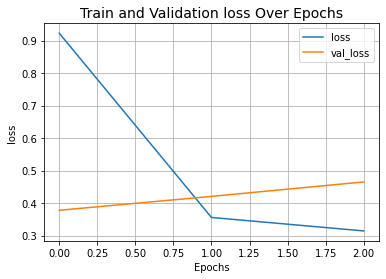

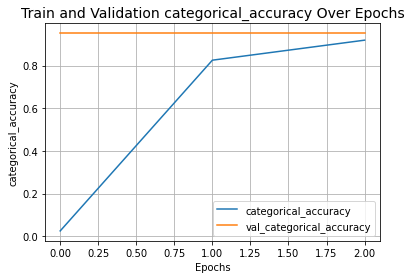

In [ ]:
epochs =  3

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

# _, categorical_acc = model.evaluate(test_dataset)
# print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

1/1 [==============================] - 0s 55ms/step - loss: 0.3807 - categorical_accuracy: 0.9254
Categorical accuracy on the test set: 92.54%.


The trained model gives us an evaluation accuracy of what is shown above.

## Inference

An important feature of the
[preprocessing layers provided by Keras](https://keras.io/guides/preprocessing_layers/)
is that they can be included inside a `tf.keras.Model`. We will export an inference model
by including the `text_vectorization` layer on top of `shallow_mlp_model`. This will
allow our inference model to directly operate on raw strings.

**Note** that during training it is always preferable to use these preprocessing
layers as a part of the data input pipeline rather than the model to avoid
surfacing bottlenecks for the hardware accelerators. This also allows for
asynchronous data processing.

In [ ]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(10), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

1/1 [==============================] - 0s 317ms/step
Text: b'Some Monday morning good news....Northern Sierra snowpack is currently 165% of normal. https://t.co/bqq8ctx1zJ'
Label(s): ['Behavioral']
Predicted Label(s): (Behavioral, Skills, Tip)
 
Text: b'Get Ready for the RAIN and SAVE OUR WATER with a Rain Barrel: http://t.co/iM6qRAiCL7 http://t.co/J8qWqQniyZ'
Label(s): ['Behavioral' 'Skills' 'Tip']
Predicted Label(s): (Behavioral, Skills, Subsidy)
 
Text: b'.@TeamCoco @ConanOBrien Joins The Effort for #CADrought! Watch the videos at http://t.co/T2s0oyTc3R  #TeamCocoH2O http://t.co/HCyGlgraIg'
Label(s): ['Behavioral']
Predicted Label(s): (Behavioral, Skills, Tip)
 
Text: b'1,800 beautiful low water use plants 2 inspire U @bewatersmart #yardmakeover #gardenlovers https://t.co/bYH0BLvW0h https://t.co/nyjr4Baxmb'
Label(s): ['Behavioral' 'Skills' 'Tip']
Predicted Label(s): (Behavioral, Skills, Subsidy)
 
Text: b'Just think how much water you can save this fall by cutting back your sprinkle

# Part 2 

## separate out information and motivation